In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re


In [2]:
sql_query = """SELECT name FROM sqlite_master  
  WHERE type='table';"""
db = "cluster-experiments/cv_results/params.db"
with sqlite3.connect(db) as con:
    cur = con.cursor()
    cur.execute(sql_query)
    print(cur.fetchall())

[('studies',), ('version_info',), ('study_directions',), ('study_user_attributes',), ('study_system_attributes',), ('trials',), ('trial_user_attributes',), ('trial_system_attributes',), ('trial_params',), ('trial_values',), ('trial_intermediate_values',), ('trial_heartbeats',), ('alembic_version',)]


In [3]:
sql_query = """SELECT * FROM trial_values;"""
with sqlite3.connect(db) as con:
    cur = con.cursor()
    cur.execute(sql_query)
    names = list(map(lambda x: x[0], cur.description))
    res = [dict(zip(names, x)) for x in cur.fetchall()] 
pd.DataFrame.from_dict(res)

,trial_value_id,trial_id,objective,value,value_type
0,16,16,0,0.000000,FINITE
1,22,32,0,0.785720,FINITE
2,34,37,0,0.744279,FINITE
3,49,49,0,0.759900,FINITE
4,64,64,0,0.819677,FINITE
...,...,...,...,...,...
3186,5445,5771,0,0.224238,FINITE
3187,5446,5758,0,0.832405,FINITE
3188,5447,5774,0,0.673970,FINITE
3189,5448,5767,0,0.532099,FINITE


In [4]:
sql_query = """SELECT * FROM studies;"""
with sqlite3.connect(db) as con:
    cur = con.cursor()
    cur.execute(sql_query)
    names = list(map(lambda x: x[0], cur.description))
    res = [dict(zip(names, x)) for x in cur.fetchall()] 
pd.DataFrame.from_dict(res)

,study_id,study_name
0,12,bert-tiny__3 -
1,21,distilroberta-base__0 -
2,23,distilroberta-base__3 -
3,70,climatebert__1 -__2
4,71,climatebert__1 -__0
...,...,...
89,283,climatebert__0 -__2
90,284,climatebert__0 -__1
91,285,climatebert__2 -__2
92,286,climatebert__2 -__1


In [5]:
sql_query = """SELECT * FROM trials;"""
with sqlite3.connect(db) as con:
    cur = con.cursor()
    cur.execute(sql_query)
    names = list(map(lambda x: x[0], cur.description))
    res = [dict(zip(names, x)) for x in cur.fetchall()] 
pd.DataFrame.from_dict(res)

,trial_id,number,study_id,state,datetime_start,datetime_complete
0,16,0,12,COMPLETE,2023-01-20 17:02:46.305244,2023-01-20 17:02:53.217821
1,32,0,21,COMPLETE,2023-01-20 18:25:55.292993,2023-01-20 18:27:39.807625
2,37,1,21,COMPLETE,2023-01-20 18:27:39.898992,2023-01-20 18:30:03.671516
3,49,2,21,COMPLETE,2023-01-20 18:30:03.761002,2023-01-20 18:33:25.177587
4,64,3,21,COMPLETE,2023-01-20 18:33:25.261029,2023-01-20 18:36:46.783340
...,...,...,...,...,...,...
3201,5773,43,281,RUNNING,2023-03-06 17:49:57.036382,None
3202,5774,18,285,COMPLETE,2023-03-06 17:50:22.584521,2023-03-06 17:52:23.631552
3203,5775,36,284,RUNNING,2023-03-06 17:50:44.780966,None
3204,5776,19,285,RUNNING,2023-03-06 17:52:23.801862,None


In [6]:
def return_search(study_name):
    sql_query = f"""
    SELECT s.study_id, s.study_name, t.trial_id, t.number, tv.value, tp.param_name, tp.param_value
    FROM trials t
    INNER JOIN 
        studies s 
    ON t.study_id = s.study_id
        AND s.study_name LIKE "%{study_name}__%"
    INNER JOIN 
        trial_values tv
    ON t.trial_id = tv.trial_id
    INNER JOIN 
        trial_params as tp
    ON
        t.trial_id = tp.trial_id;
    """
    with sqlite3.connect(db) as con:
        cur = con.cursor()
        cur.execute(sql_query)
        names = list(map(lambda x: x[0], cur.description))
        res = [dict(zip(names, x)) for x in cur.fetchall()] 
    df = pd.DataFrame.from_dict(res)
    return df




scincl__0 -__0
scincl__0 -__1
scincl__0 -__2


,study_id,study_name,trial_id,number,value,param_name,param_value
0,264,scincl__0 -__0,4710,0,0.0,learning_rate,0.000001
1,264,scincl__0 -__0,4710,0,0.0,num_train_epochs,3.000000
2,264,scincl__0 -__0,4710,0,0.0,per_device_train_batch_size,0.000000
3,264,scincl__0 -__0,4710,0,0.0,use_class_weights,0.000000
4,264,scincl__0 -__0,4710,0,0.0,weight_decay,0.059873


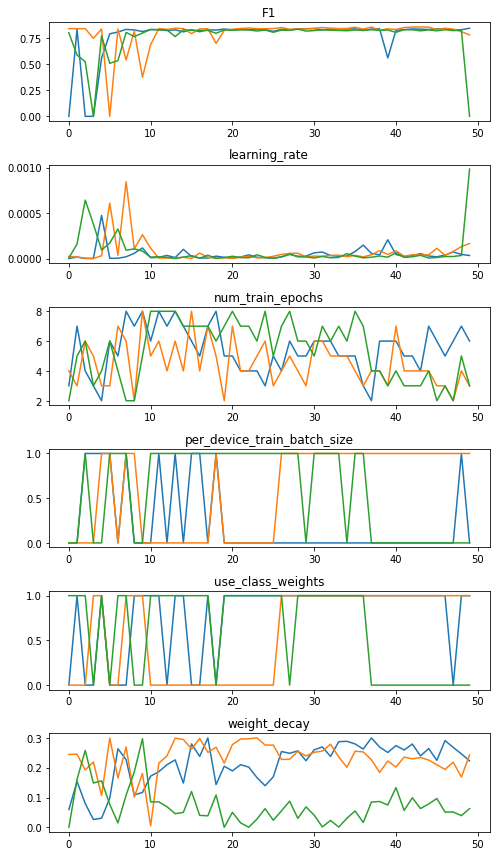

In [7]:
model_name = "scincl"
y_prefix = "0 -"
study_name = f"{model_name}__{y_prefix}"
df = return_search(study_name)

fig, axs = plt.subplots(6, figsize=(7,12))
for fold, group in df.groupby("study_name"):
    print(fold)
    vals = group.groupby("number")["value"].mean()
    axs[0].plot(vals)
    for i, (p, pgroup) in enumerate(group.groupby("param_name")):
        pgroup = pgroup.sort_values("number").reset_index(drop=True)
        axs[i+1].plot(pgroup["param_value"])
        axs[i+1].set_title(p)
        
axs[0].set_title("F1")
        
fig.tight_layout()
df.head()

scincl__3 -__0
scincl__3 -__1
scincl__3 -__2


,study_id,study_name,trial_id,number,value,param_name,param_value
0,272,scincl__3 -__2,4946,0,0.0,learning_rate,0.000546
1,272,scincl__3 -__2,4946,0,0.0,num_train_epochs,2.000000
2,272,scincl__3 -__2,4946,0,0.0,per_device_train_batch_size,0.000000
3,272,scincl__3 -__2,4946,0,0.0,use_class_weights,1.000000
4,272,scincl__3 -__2,4946,0,0.0,weight_decay,0.231887


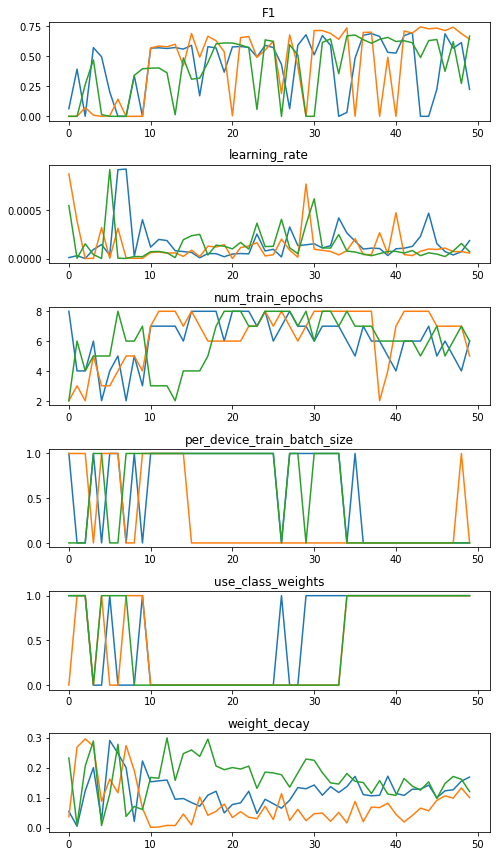

In [8]:
model_name = "scincl"
y_prefix = "3 -"
study_name = f"{model_name}__{y_prefix}"
df = return_search(study_name)

fig, axs = plt.subplots(6, figsize=(7,12))
for fold, group in df.groupby("study_name"):
    print(fold)
    vals = group.groupby("number")["value"].mean()
    axs[0].plot(vals)
    for i, (p, pgroup) in enumerate(group.groupby("param_name")):
        pgroup = pgroup.sort_values("number").reset_index(drop=True)
        axs[i+1].plot(pgroup["param_value"])
        axs[i+1].set_title(p)
        
axs[0].set_title("F1")
        
fig.tight_layout()
df.head()

climatebert__5 -__0
climatebert__5 -__1
climatebert__5 -__2


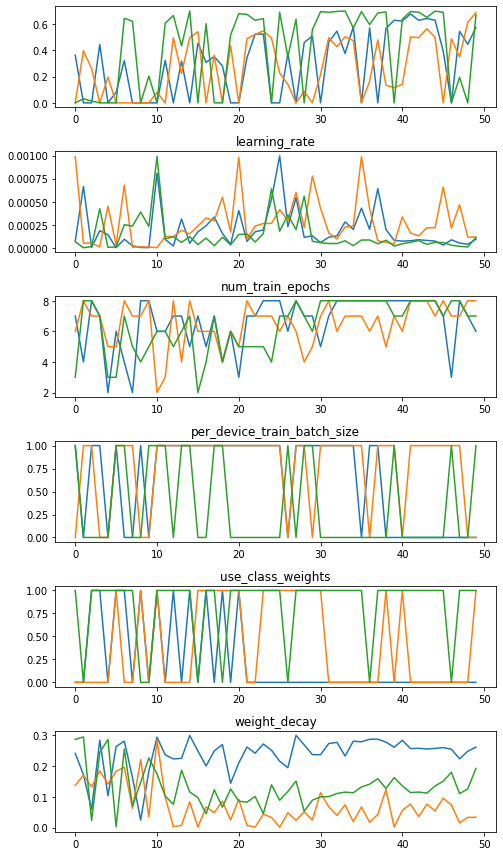

In [9]:
model_name = "climatebert"
y_prefix = "5 -"
study_name = f"{model_name}__{y_prefix}"
df = return_search(study_name)

fig, axs = plt.subplots(6, figsize=(7,12))
axs[0]
for fold, group in df.groupby("study_name"):
    print(fold)
    vals = group.groupby("number")["value"].mean()
    axs[0].plot(vals)
    for i, (p, pgroup) in enumerate(group.groupby("param_name")):
        pgroup = pgroup.sort_values("number").reset_index(drop=True)
        axs[i+1].plot(pgroup["param_value"])
        axs[i+1].set_title(p)
        
fig.tight_layout()

In [10]:
import json

models = ["climatebert","distilroberta-base"]
models = ["bert-tiny", "distilroberta-base"]
models = ["bert-tiny","climatebert", "distilroberta-base","scincl"]
ys = ["0 -", "3 -"]
ys = ["0 -"]
ys = ["0 -","2 -","3 -","4 -","5 -","6 -"]
#ys = ["2 -", "3 -", "4 -"]
scores = []
for model_name in models:
    for y in ys:
        for k in range(3):
            study_name = f"{model_name}__{y}__{k}"
            print(study_name)
            try:
                with open(f"cluster-experiments/cv_results/{study_name}.json", "r") as f:
                    res = json.load(f)
                    try:
                        res = {**res["hyperparameters"],**res["scores"],**res["evaluated_scores"]}
                    except:
                        print("Could not load evaluated_scores")
                        continue
                    res["model"] = model_name
                    res["y"] = y
                    res["k"] = k
                    scores.append(res)
            except FileNotFoundError:
                print("Could not find file")


bert-tiny__0 -__0
bert-tiny__0 -__1
bert-tiny__0 -__2
bert-tiny__2 -__0
bert-tiny__2 -__1
bert-tiny__2 -__2
bert-tiny__3 -__0
bert-tiny__3 -__1
bert-tiny__3 -__2
bert-tiny__4 -__0
bert-tiny__4 -__1
bert-tiny__4 -__2
bert-tiny__5 -__0
bert-tiny__5 -__1
bert-tiny__5 -__2
bert-tiny__6 -__0
bert-tiny__6 -__1
bert-tiny__6 -__2
climatebert__0 -__0
climatebert__0 -__1
climatebert__0 -__2
climatebert__2 -__0
climatebert__2 -__1
climatebert__2 -__2
climatebert__3 -__0
climatebert__3 -__1
climatebert__3 -__2
climatebert__4 -__0
climatebert__4 -__1
climatebert__4 -__2
climatebert__5 -__0
climatebert__5 -__1
climatebert__5 -__2
climatebert__6 -__0
climatebert__6 -__1
climatebert__6 -__2
distilroberta-base__0 -__0
distilroberta-base__0 -__1
distilroberta-base__0 -__2
distilroberta-base__2 -__0
distilroberta-base__2 -__1
distilroberta-base__2 -__2
distilroberta-base__3 -__0
distilroberta-base__3 -__1
distilroberta-base__3 -__2
distilroberta-base__4 -__0
distilroberta-base__4 -__1
distilroberta-base_

In [11]:
cdict = {
    "0 -": "Relevance",
    "2 -": "Climate driver",
    "3 -": "Health impact",
    "4 -": "Attribution type",
    "5 -": "Extreme event",
    "6 -": "Exposure"
}

In [15]:
score_df = pd.DataFrame.from_dict(scores)
naf1 = pd.isna(score_df["F1"])
score_df.loc[naf1,"F1"] = score_df.loc[naf1,"F1 macro"]
def mean_std(x):
    m = np.mean(x)
    sd = np.std(x)
    return f"{m:.2f} ({sd:.2f})"
score_tab = score_df.pivot_table(index="y",columns="model",values="F1", aggfunc=mean_std).reset_index()

score_tab.columns.name = None
score_tab["y"] = score_tab["y"].apply(lambda x: cdict[x])
score_tab = score_tab.rename(columns={"y":"Category"}).fillna("")
vis = score_tab.style.highlight_max(
    subset=models,
    props='font-weight:bold;',
    #props='color:red',
    axis=1
).hide()
out = score_tab.style.highlight_max(
    subset=models,
    props='textbf:--rwrap',
    #props='color:red',
    axis=1,
).hide()
out.to_latex(
    "tables/predictions.tex",
    hrules=True
)
vis

Category,bert-tiny,climatebert,distilroberta-base,scincl
Relevance,0.44 (0.29),0.85 (0.01),0.82 (0.02),0.84 (0.02)
Climate driver,0.54 (0.00),0.44 (0.23),0.55 (0.01),0.61 (0.06)
Health impact,0.21 (0.11),0.59 (0.04),0.58 (0.01),0.68 (0.06)
Attribution type,0.13 (0.03),0.58 (0.05),0.50 (0.05),0.60 (0.02)
Extreme event,0.01 (0.02),0.73 (0.07),0.71 (0.09),0.66 (0.01)
Exposure,0.00 (0.00),0.36 (0.11),0.36 (0.11),0.51 (0.14)


In [13]:
def sub_results(y):
    sub_df = score_df[score_df["y"]==y]
    cols = [x for x in score_df.columns if re.match(f"F1 - {y}",x)]
    sub_df = sub_df.melt(id_vars=["k","model"], value_vars=cols)
    sub_df["variable"] = sub_df["variable"].apply(lambda x: x.split(".")[2])
    piv = sub_df.pivot_table(index="variable",columns="model",values="value", aggfunc=mean_std).reset_index()
    piv.columns.name = None
    piv = piv.rename(columns={"variable":"Sub-category"}).style.highlight_max(
        props='font-weight:bold;',
        axis=1
    )

    return piv

tab = sub_results("2 -")
tab

,Sub-category,bert-tiny,climatebert,distilroberta-base,scincl
0,CO2 rise,0.0 (0.0),0.0 (0.0),0.0 (0.0),0.13 (0.19)
1,Changes in precipitation,0.9 (0.016),0.59 (0.42),0.89 (0.019),0.9 (0.031)
2,Changes in temperature,0.92 (0.0014),0.86 (0.093),0.94 (0.015),0.94 (0.0054)
3,Climate change (unspecified),0.74 (0.037),0.49 (0.34),0.71 (0.026),0.8 (0.021)
4,Other meteorological variables,0.69 (0.027),0.53 (0.38),0.79 (0.031),0.8 (0.01)
5,Seasonal change,0.0 (0.0),0.19 (0.14),0.0 (0.0),0.11 (0.16)


In [14]:
tab = sub_results("3 -")
tab

,Sub-category,bert-tiny,climatebert,distilroberta-base,scincl
0,Cardiorespiratory disease,0.27 (0.34),0.79 (0.044),0.78 (0.038),0.74 (0.073)
1,Direct injury and death,0.0 (0.0),0.36 (0.18),0.34 (0.16),0.5 (0.15)
2,Food security,0.11 (0.16),0.73 (0.061),0.65 (0.064),0.8 (0.12)
3,Health system capacity,0.029 (0.021),0.13 (0.19),0.37 (0.26),0.51 (0.16)
4,Infectious diseases,0.7 (0.15),0.94 (0.019),0.9 (0.015),0.89 (0.036)
5,Mental health and sentiment,0.19 (0.12),0.87 (0.031),0.86 (0.018),0.95 (0.024)
6,Mortality and morbidity,0.23 (0.33),0.78 (0.037),0.73 (0.05),0.77 (0.053)
7,Other health impacts,0.34 (0.044),0.63 (0.029),0.42 (0.27),0.55 (0.11)
8,Water security,0.038 (0.031),0.095 (0.13),0.2 (0.15),0.4 (0.16)


In [15]:
tab = sub_results("4 -")
tab

,Sub-category,bert-tiny,climatebert,distilroberta-base,scincl
0,Climate change attribution,0.0 (0.0),0.57 (0.077),0.53 (0.04),0.69 (0.033)
1,Climate sensitivity,0.57 (0.19),0.9 (0.014),0.88 (0.017),0.88 (0.023)
2,Extreme event attribution,0.0 (0.0),0.77 (0.0092),0.77 (0.0094),0.83 (0.051)
3,Scenarios,0.072 (0.1),0.65 (0.17),0.34 (0.24),0.58 (0.062)
4,Trend attribution,0.0 (0.0),0.0 (0.0),0.0 (0.0),0.0 (0.0)


In [16]:
tab = sub_results("5 -")
tab

,Sub-category,bert-tiny,climatebert,distilroberta-base,scincl
0,Extreme cold,0.0082 (0.012),0.33 (0.24),0.3 (0.21),0.0 (0.0)
1,Floods and drought,0.0 (0.0),0.93 (0.036),0.94 (0.014),0.93 (0.043)
2,Heatwaves,0.0 (0.0),0.72 (0.071),0.66 (0.12),0.73 (0.045)
3,Other extreme events,0.0 (0.0),0.81 (0.074),0.78 (0.099),0.85 (0.048)
4,Wildfires,0.051 (0.073),0.86 (0.0084),0.85 (0.016),0.81 (0.066)


In [17]:
tab = sub_results("6 -")
tab

,Sub-category,bert-tiny,climatebert,distilroberta-base,scincl
0,"Biodiversity loss, ecosystem & microbial change",0.0078 (0.011),0.0 (0.0),0.13 (0.19),0.0 (0.0)
1,Pollution,0.0 (0.0),0.84 (0.024),0.82 (0.033),0.82 (0.056)
2,Reduced agricultural & aquaculture productivity,0.0 (0.0),0.33 (0.24),0.21 (0.15),0.46 (0.15)
3,Reduced labour and physical capacity,0.0 (0.0),0.27 (0.25),0.28 (0.28),0.52 (0.11)
